In [109]:
import numpy as np
import json
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [110]:
# https://stackoverflow.com/questions/62722416/plot-confusion-matrix-for-multilabel-classifcation-python
def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    axes.set_ylabel('True label')
    axes.set_xlabel('Predicted label')
    axes.set_title("Confusion Matrix for the class - " + class_label)

In [111]:
# Загружаем предвычесленные фичи
OPENMIC = np.load('data/openmic-2018/openmic-2018.npz', allow_pickle=True)
X, Y_true, Y_mask, sample_key = OPENMIC['X'], OPENMIC['Y_true'], OPENMIC['Y_mask'], OPENMIC['sample_key']

# Загружаем словарь-маппер инструментов
with open('data/openmic-2018/class-map.json', 'r') as f:
    instrument_to_idx = json.load(f)

idx_to_instrument = { value:key for key, value in instrument_to_idx.items()}

# Создатели open-mic-2018 разделили на тренировочную и тестовые выборки по 14915 и 5085 соответственно
split_train = set(pd.read_csv('data/openmic-2018/partitions/split01_train.csv',
                          header=None).squeeze())

split_test = set(pd.read_csv('data/openmic-2018/partitions/split01_test.csv',
                         header=None).squeeze())

train_set = set(split_train)
test_set = set(split_test)

idx_train, idx_test = [], []

for idx, n in enumerate(sample_key):
    if n in train_set:
        idx_train.append(idx)
    elif n in test_set:
        idx_test.append(idx)
    else:
        raise RuntimeError('Unknown sample key={}! Abort!'.format(sample_key[n]))

# Получаем индексы, по которым будем делить данные
idx_train = np.asarray(idx_train)
idx_test = np.asarray(idx_test)

# Sample[n] : timestamp[10] : features[128]
X_train = X[idx_train]
X_test = X[idx_test]

# Sample[n] : Уверенности в наличие инструмента[20]
Y_true_train = Y_true[idx_train]
Y_true_test = Y_true[idx_test]

# Sample[n] : Известно ли наличие инструмента[20]
Y_mask_train = Y_mask[idx_train]
Y_mask_test = Y_mask[idx_test]

In [112]:
def classify():
    models = dict()

    # Трешхолд уверенности в наличии инструмента
    treshold = 0.5

    train_conf_matrices = []
    test_conf_matrices = []

    # Проходим по всем инструментам
    for instrument in instrument_to_idx:

        # Выбираем id инструмента
        inst_num = instrument_to_idx[instrument]

        # Получаем маску для инструментов
        train_inst = Y_mask_train[:, inst_num]
        test_inst = Y_mask_test[:, inst_num]

        # Выбираем только те x и y, в которых было измерено наличие или отсутствие инструмента
        X_train_inst = X_train[train_inst]
        X_test_inst = X_test[test_inst]

        # Если confidence в инструменте >0.5 то считаем что он есть в песне
        Y_true_train_inst = Y_true_train[train_inst, inst_num] >= treshold
        Y_true_test_inst = Y_true_test[test_inst, inst_num] >= treshold

        # Усредняем массив vggish фичей для получения 1 вектора вместо time-varying
        X_train_inst_avg = np.mean(X_train_inst, axis=1)
        X_test_inst_avg = np.mean(X_test_inst, axis=1)

        # Инициализируем классификатор
        clf = RandomForestClassifier(max_depth=8, n_estimators=100, random_state=0)

        # Обучаем
        clf.fit(X_train_inst_avg, Y_true_train_inst)

        # Сохраняем модель
        models[instrument] = clf

        # Предсказываем трейн и тест
        Y_pred_train = clf.predict(X_train_inst_avg)
        Y_pred_test = clf.predict(X_test_inst_avg)

        # Строим classification_report для тренировочного и тестового датасета
        print('-' * 52)
        print(instrument)


        print('\tTRAIN')
        train_conf_matrices.append(confusion_matrix(Y_true_train_inst, Y_pred_train))
        print(classification_report(Y_true_train_inst, Y_pred_train))


        print('\tTEST')
        test_conf_matrices.append(confusion_matrix(Y_true_test_inst, Y_pred_test))
        print(classification_report(Y_true_test_inst, Y_pred_test))

    return models, train_conf_matrices, test_conf_matrices

In [113]:
models, train_conf_matrices, test_conf_matrices = classify()

----------------------------------------------------
accordion
	TRAIN
              precision    recall  f1-score   support

       False       0.96      1.00      0.98      1159
        True       1.00      0.88      0.94       374

    accuracy                           0.97      1533
   macro avg       0.98      0.94      0.96      1533
weighted avg       0.97      0.97      0.97      1533

	TEST
              precision    recall  f1-score   support

       False       0.84      0.97      0.90       423
        True       0.77      0.32      0.45       115

    accuracy                           0.83       538
   macro avg       0.81      0.65      0.68       538
weighted avg       0.83      0.83      0.81       538

----------------------------------------------------
banjo
	TRAIN
              precision    recall  f1-score   support

       False       0.98      0.98      0.98      1148
        True       0.97      0.97      0.97       592

    accuracy                           0

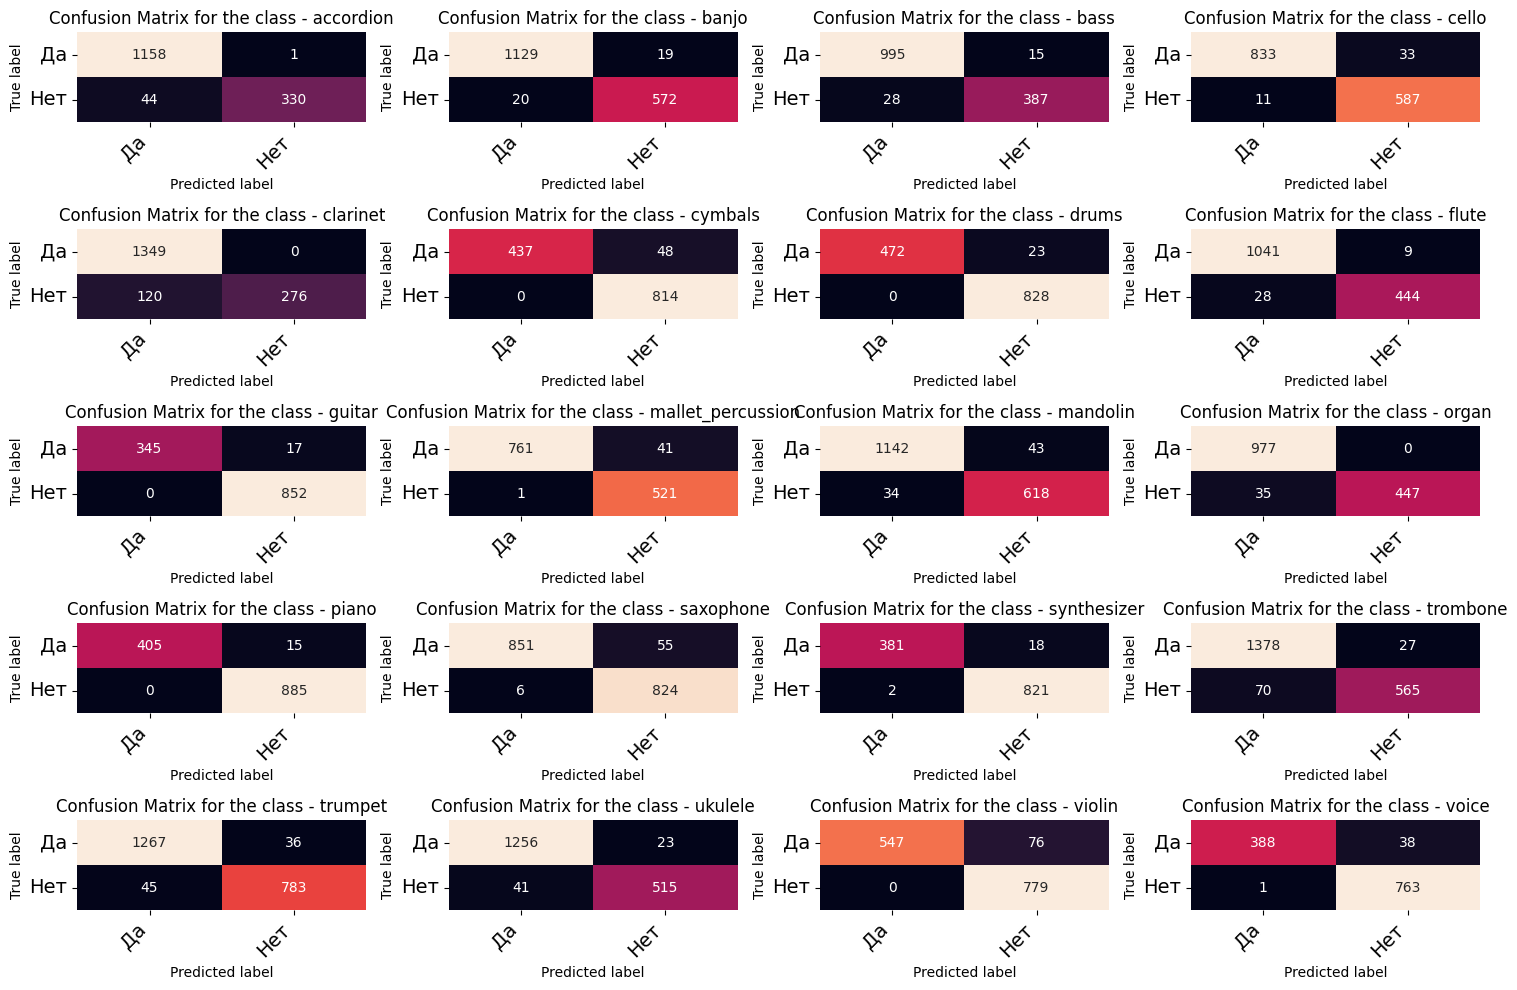

In [114]:
fig, ax = plt.subplots(5, 4, figsize=(15, 10))

labels = instrument_to_idx.keys()
vis_arr = train_conf_matrices
for axes, cfs_matrix, label in zip(ax.flatten(), vis_arr, labels):
    print_confusion_matrix(cfs_matrix, axes, label, ["Да", "Нет"])

fig.tight_layout()
plt.show()

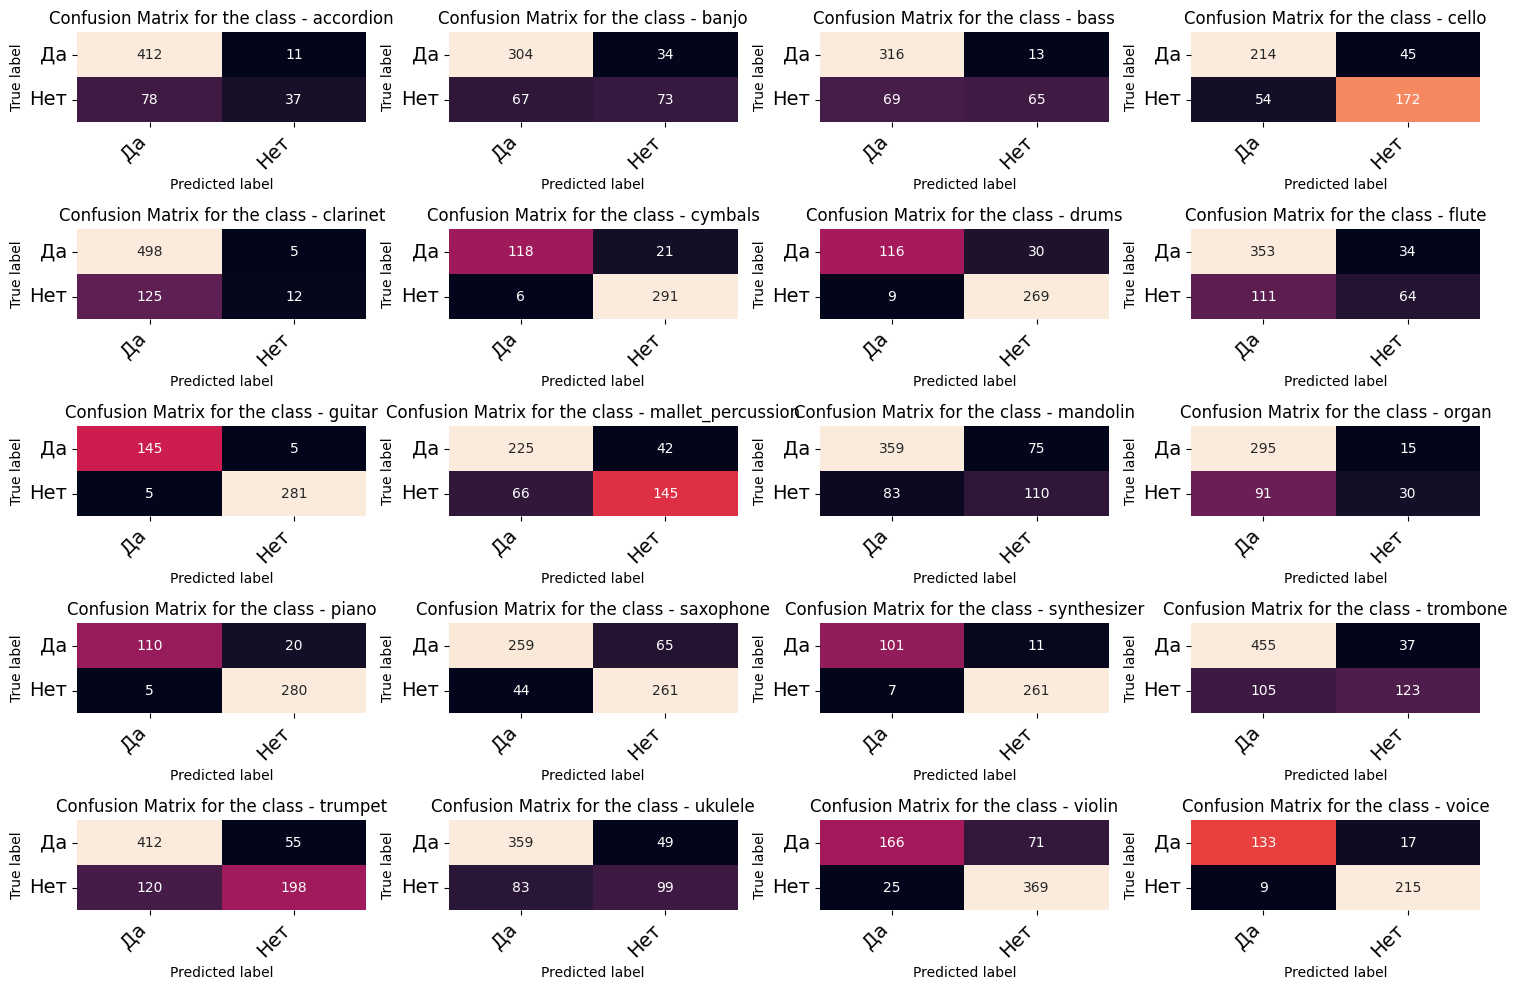

In [115]:
fig, ax = plt.subplots(5, 4, figsize=(15, 10))

labels = instrument_to_idx.keys()
vis_arr = test_conf_matrices
for axes, cfs_matrix, label in zip(ax.flatten(), vis_arr, labels):
    print_confusion_matrix(cfs_matrix, axes, label, ["Да", "Нет"])

fig.tight_layout()
plt.show()

In [133]:
def evaluate_global(models, X, Y_mask, Y_true, treshold = 0.5):
    # Проходим по каждой песне
    for i, (x, y_mask, y_true) in enumerate(zip(X, Y_mask, Y_true)):
        x_avg = np.mean(x, axis=0)
        y_true_thresh = y_true >= treshold
        y_true_thresh = y_true_thresh * y_mask

        predictions = []
        real = []

        # По индексам инструментов которые были оценены:
        for index in np.where(y_mask)[0]:
            instrument = idx_to_instrument[index]
            prediction = models[instrument].predict([x_avg])[0]
            predictions.append(prediction)

            real.append(y_true_thresh[index])

        print(predictions, real)

        if i > 10:
            break

In [134]:
evaluate_global(models, X_test, Y_mask_test, Y_true_test, 0.5)

[True] [True]
[True, False] [True, False]
[False] [False]
[False] [True]
[False, True] [False, True]
[True] [True]
[True, False] [True, False]
[True, True] [True, True]
[True] [True]
[False, False, False, False] [False, True, False, False]
[False, False] [False, False]
[False] [False]


In [138]:
import torch

model = torch.hub.load('harritaylor/torchvggish', 'vggish')
model.eval()
;

Using cache found in /home/araxal/.cache/torch/hub/harritaylor_torchvggish_master


''

In [139]:
zxc = model.forward('data/test.mp3').cpu().detach().numpy()
feature_mean = np.mean(zxc, axis=0, keepdims=True)

for instrument in models:

    clf = models[instrument]

    print('P[{:18s}=1] = {:.3f}'.format(instrument, clf.predict_proba(feature_mean)[0,1]))

P[accordion         =1] = 0.103
P[banjo             =1] = 0.100
P[bass              =1] = 0.316
P[cello             =1] = 0.116
P[clarinet          =1] = 0.067
P[cymbals           =1] = 0.738
P[drums             =1] = 0.881
P[flute             =1] = 0.236
P[guitar            =1] = 0.311
P[mallet_percussion =1] = 0.425
P[mandolin          =1] = 0.130
P[organ             =1] = 0.074
P[piano             =1] = 0.404
P[saxophone         =1] = 0.234
P[synthesizer       =1] = 0.824
P[trombone          =1] = 0.208
P[trumpet           =1] = 0.201
P[ukulele           =1] = 0.095
P[violin            =1] = 0.320
P[voice             =1] = 0.296
